## Threshold irradiance vs. pulse width and distance

Here we will replicate figure 3 of Foutz et al., 2012 for different model combos:

| Original | Replicated|
| - | - |
| ![Foutz et al., 2012 Figure 3](img/orig/foutz12_3.jpg) | ![Replication of Foutz et al., 2012 Figure 3](img/repl/foutz12_3.svg)|

In [9]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(['seaborn-paper'])
matplotlib.rcParams['font.sans-serif'] = "Open Sans"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from cleosim import CLSimulator
from cleosim.opto import *
from cleosim.coordinates import assign_coords_grid_rect_prism
from brian2 import SpikeMonitor, Network, prefs
prefs.codegen.target = 'cython'

def get_Irr0_thres(pulse_widths, distance_mm, ng, precision=1, simple_opto=False):
    mon = SpikeMonitor(ng, record=False)

    assign_coords_grid_rect_prism(
        ng,
        xlim=(0, 0),
        ylim=(0, 0),
        zlim=(distance_mm, distance_mm),
        unit=mm,
        shape=(1, 1, 1),
    )

    net = Network(mon, ng)
    sim = CLSimulator(net)

    if simple_opto:
        opto = OptogeneticIntervention(
            name="opto",
            opsin_model=ProportionalCurrentModel(
                # use 240*(thresh-E_L) factor from tutorial
                Iopto_per_mW_per_mm2=240 * (20 * mV) / (500 * Mohm)
            ),
            light_model_params=default_blue,
            location=(0, 0, 0) * mm,
        )
    else:
        opto = OptogeneticIntervention(
            name="opto",
            opsin_model=FourStateModel(ChR2_four_state),
            light_model_params=default_blue,
            location=(0, 0, 0) * mm,
        )
    sim.inject_stimulator(opto, ng)

    sim.network.store()
    Irr0_thres = []
    for pw in pulse_widths:
        search_min, search_max = (0, 10000)
        while (
            search_max - search_min > precision
        ):  # get down to {precision} mW/mm2 margin
            sim.network.restore()
            Irr0_curr = (search_min + search_max) / 2
            opto.update(Irr0_curr)
            sim.run(pw * ms)
            opto.update(0)
            sim.run(10 * ms)  # wait 10 ms to make sure only 1 spike
            if mon.count > 0:  # spiked
                search_max = Irr0_curr
            else:
                search_min = Irr0_curr
        Irr0_thres.append(Irr0_curr)

    return Irr0_thres


We prepare a pandas dataframe in tidy format:

In [66]:
import pandas as pd
df = pd.DataFrame(columns=["name", "distance", "pulse_width", "threshold"])
df

,name,distance,pulse_width,threshold


We need to get the original data for comparison:

In [67]:
wpd_data = pd.read_csv('data/foutz12_3_wpd.csv')
wpd_data.head()

,1.5 mm,Unnamed: 1,1.0 mm,Unnamed: 3,0.5 mm,Unnamed: 5
0,X,Y,X,Y,X,Y
1,2.8036529680365296,2004.8387096774195,1.4155251141552503,2000,0.6392694063926934,2000
2,2.9132420091324196,1830.6451612903227,1.5981735159817338,1554.8387096774195,0.6849315068493147,1666.1290322580646
3,3.1050228310502277,1661.2903225806454,1.9726027397260264,1061.2903225806451,0.7853881278538806,1322.5806451612905
4,3.4063926940639266,1438.7096774193549,2.5114155251141543,679.0322580645161,0.8812785388127846,1032.258064516129


In [68]:
for i_col in [0, 2, 4]:
    for i_row in range(1, len(wpd_data)):
        if pd.isna(wpd_data.iloc[i_row, i_col]):
            continue
        df.loc[len(df)] = [
            "Foutz et al., 2012",
            wpd_data.columns[i_col],
            wpd_data.iloc[i_row, i_col],
            wpd_data.iloc[i_row, i_col + 1],
        ]
df.pulse_width = df.pulse_width.astype(float)
df.threshold = df.threshold.astype(float)


In [69]:
df.tail()

,name,distance,pulse_width,threshold
41,"Foutz et al., 2012",0.5 mm,4.365297,54.838710
42,"Foutz et al., 2012",0.5 mm,5.132420,40.322581
43,"Foutz et al., 2012",0.5 mm,5.707763,35.483871
44,"Foutz et al., 2012",0.5 mm,6.730594,11.290323
45,"Foutz et al., 2012",0.5 mm,9.990868,6.451613


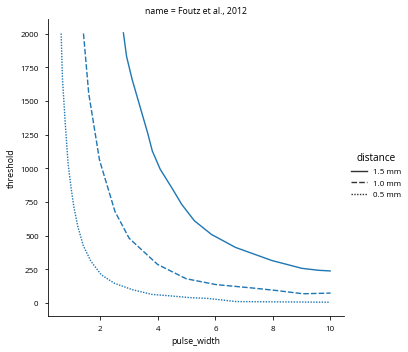

In [70]:
def plot_thresh(data):
    sns.relplot(
        data=data,
        kind="line",
        col='name',
        x="pulse_width",
        y="threshold",
        units="distance",
        style="distance",
        estimator=None,
    )

plot_thresh(df)

Looks right. Time to test the models.

In [71]:
from opto_val import lif, adex

pulse_widths = np.arange(0.2, 10.2, 5)
for ng_constructor in [lif, adex]:
    for simple_opto in [True, False]:
        for dist in [1.5, 1, 0.5]:
            ng = ng_constructor(1)
            Irr0_thres = get_Irr0_thres(pulse_widths, dist, ng, simple_opto=simple_opto)
            opsin_name = "simple" if simple_opto else "Markov"
            name = f"{ng.name} + {opsin_name} opsin"
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "name": name,
                            "distance": f"{dist} mm",
                            "pulse_width": pulse_widths,
                            "threshold": Irr0_thres,
                        }
                    ),
                ]
            )
df = df.reset_index(drop=True)
df.to_csv("data/thresholds.csv", index=False)
df.tail()

INFO       No numerical integration method specified for group 'AdEx', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


,name,distance,pulse_width,threshold
1,AdEx + Markov opsin,1.5 mm,5.2,61.645508
0,AdEx + Markov opsin,1 mm,0.2,894.165039
1,AdEx + Markov opsin,1 mm,5.2,16.479492
0,AdEx + Markov opsin,0.5 mm,0.2,155.639648
1,AdEx + Markov opsin,0.5 mm,5.2,3.051758


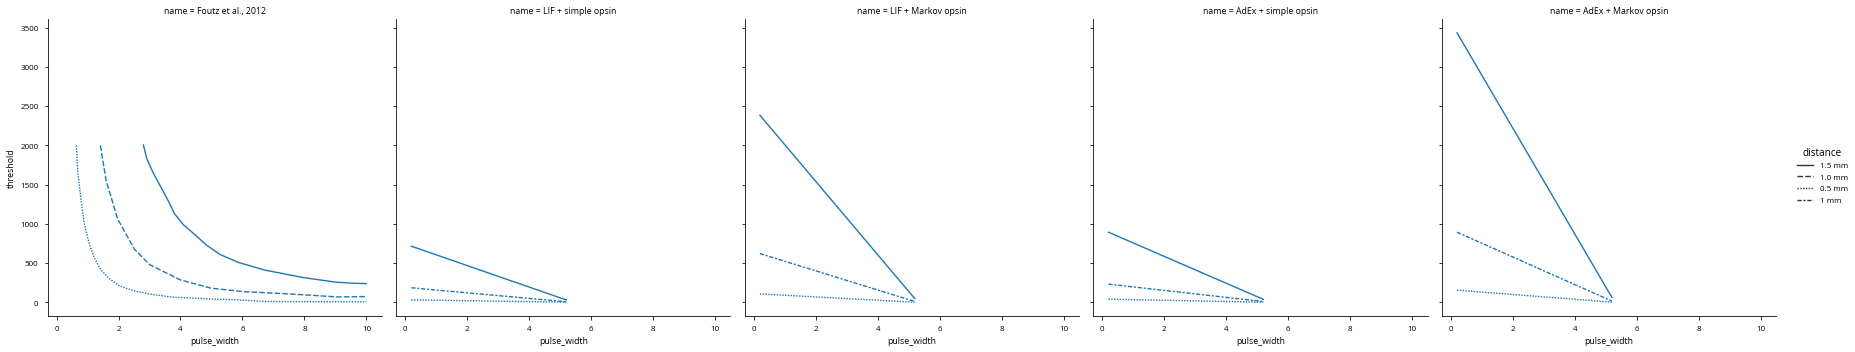

In [78]:
plot_thresh(df)

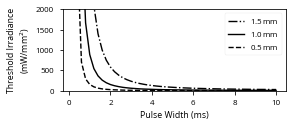

In [ ]:
fig, ax = plt.subplots(figsize=(4, 1.5))
ax.plot(pulse_widths, Irr0_thres_15, 'k-.', label='1.5$\,$mm')
ax.plot(pulse_widths, Irr0_thres_10, 'k-', label='1.0$\,$mm')
ax.plot(pulse_widths, Irr0_thres_05, 'k--', label='0.5$\,$mm')
ax.set(ylim=(0, 2000), ylabel='Threshold Irradiance\n(mW/mm$^2$)', xlabel='Pulse Width (ms)')
ax.legend();
fig.savefig('foutz12_3_replicated.svg', facecolor='white', bbox_inches='tight')

We need to note the threshold irradiance for a 5 ms pulse at 1 mm distance for the next experiment:

In [ ]:
Irr0_thres = {}
ng_lif, ng_eif = make_ngs(1)
Irr0_thres['LIF'] = get_Irr0_thres([5], 1, ng_lif, precision=0.001, simple_opto=True)[0]
Irr0_thres['EIF_simple'] = get_Irr0_thres([5], 1, ng_eif, precision=0.001, simple_opto=True)[0]
_, ng_eif = make_ngs(1)
Irr0_thres['EIF_markov'] = get_Irr0_thres([5], 1, ng_eif, precision=0.001)[0]
Irr0_thres

{'LIF': 8.3845853805542,
 'EIF_simple': 10.301470756530762,
 'EIF_markov': 16.930699348449707}